In [1]:

import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


df = pd.read_excel('../../data_set/hd_sessions/data_cleaned.xlsx')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3856 entries, 0 to 3855
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Subject_ID           3856 non-null   object        
 1   Session_No           3856 non-null   object        
 2   Date                 3843 non-null   datetime64[ns]
 3   AP (mmHg)            3856 non-null   float64       
 4   AUF (ml)             3856 non-null   float64       
 5   BFR (ml/min)         3856 non-null   float64       
 6   Dry weight (kg)      3856 non-null   float64       
 7   HD duration (h)      3856 non-null   float64       
 8   PUF (ml)             3856 non-null   float64       
 9   Post HD weight (kg)  3856 non-null   float64       
 10  Pre HD weight (kg)   3856 non-null   float64       
 11  TMP (mmHg)           3856 non-null   float64       
 12  VP (mmHg)            3856 non-null   int64         
 13  Weight gain (kg)     3856 non-nul

In [3]:
df['target'] = df['SYS (mmHg)'].apply(lambda x: 1 if x <= 90 else 0)

In [4]:
df.drop(columns=['SYS (mmHg)'], inplace=True)

In [5]:
X = df.drop(columns=['target', 'Subject_ID', 'Session_No', 'Date']) 
y = df['target']     

In [6]:
X.columns

Index(['AP (mmHg)', 'AUF (ml)', 'BFR (ml/min)', 'Dry weight (kg)',
       'HD duration (h)', 'PUF (ml)', 'Post HD weight (kg)',
       'Pre HD weight (kg)', 'TMP (mmHg)', 'VP (mmHg)', 'Weight gain (kg)',
       'DIA (mmHg)'],
      dtype='object')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

In [9]:
balanced_class_distribution = y_train.value_counts()
print("Class distribution before balancing:")
print(balanced_class_distribution)


Class distribution before balancing:
target
0    3073
1      11
Name: count, dtype: int64


In [10]:
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [11]:
balanced_class_distribution = y_train_resampled.value_counts()
print("Class distribution after balancing:")
print(balanced_class_distribution)

Class distribution after balancing:
target
0    3073
1    3073
Name: count, dtype: int64


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}
Best ROC AUC score: 0.9990132676571065
Accuracy: 0.9896373056994818
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       769
           1       0.22      0.67      0.33         3

    accuracy                           0.99       772
   macro avg       0.61      0.83      0.66       772
weighted avg       1.00      0.99      0.99       772

Confusion Matrix:
 [[762   7]
 [  1   2]]
ROC AUC Score: 0.9111400086692674


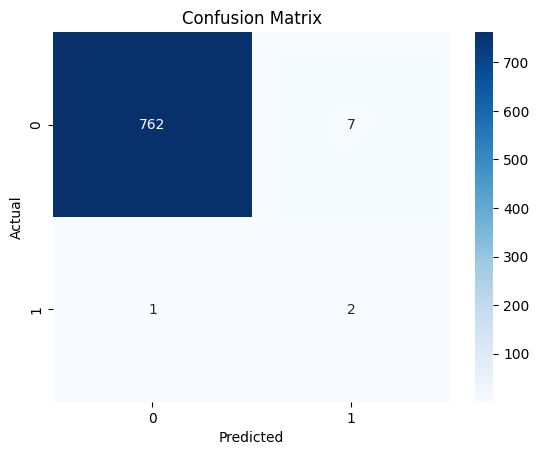

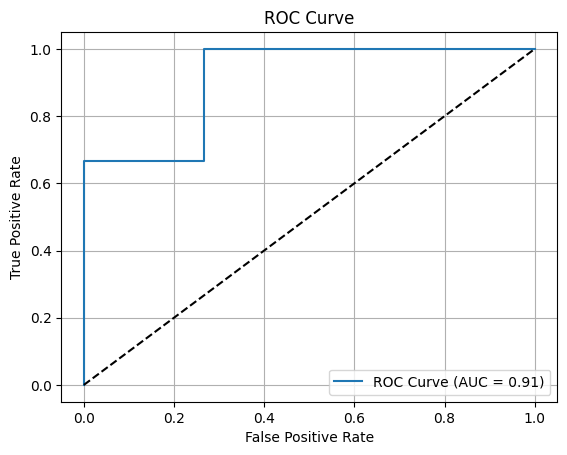

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# # Define and train the MLP model
# mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=300, random_state=42)
# mlp.fit(X_train_resampled, y_train_resampled)

# # Predict on test set
# y_pred = mlp.predict(X_test_scaled)
# y_prob = mlp.predict_proba(X_test_scaled)[:, 1]  # for ROC AUC

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [300]
}

mlp = MLPClassifier(random_state=42)

# Use GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters found:", grid_search.best_params_)
print("Best ROC AUC score:", grid_search.best_score_)

# Use the best estimator to predict
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test_scaled)
y_prob = best_mlp.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Plot Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
